##Dependencies

In [1]:
import logging
logging.basicConfig(filename='whaaaat.log', level=logging.DEBUG)
logging.info('Ready to log.')

def log_print(text, level='info'):
    print(text)
    if level=='info':
        logging.info(text)
    elif level=='error':
        logging.error(text)
    else:
        logging.debug(text)


In [2]:
import scipy
import pandas as pd
import numpy as np
import eli5
from sklearn_crfsuite import metrics, scorers, CRF
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin 
import pickle
from datetime import datetime as dt
import spacy
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os

log_print('Imports successful.')

Using TensorFlow backend.
C:\Users\Lewis.Bails\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lewis.Bails\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lewis.Bails\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

##Inspect

In [3]:
def get_frames(path, k_fold=True):
    data = {i:pd.read_csv(path+f'{i}.csv', index_col=['sentence_id','token_id']).fillna(value={'token': 'NA'}) for i in ('train','validation','test')}

    if k_fold:
        offset = data['train'].index.max(0)[0]+1
        df = data['validation']
        df.index = df.index.set_levels(df.index.levels[0]+offset, level=0)
        data['train'] = pd.concat([data['train'],data['validation']], verify_integrity=True)

    return data

In [4]:
try:
    path = '../data/' if 'src' in os.getcwd() else './data/'
    data_conll = get_frames(path+'conll/')
    data_wnut = get_frames(path+'wnut/')

    logging.info('Frames loaded from file.')
except Exception as e:
    logging.error(f'Failed: {e}')
    raise e

In [5]:
tag_map = {
    'B-product':'B-MISC',
    'I-product':'I-MISC',
    'B-creative-work':'B-MISC',
    'I-creative-work':'I-MISC',
    'B-corporation':'B-ORG',
    'I-corporation':'I-ORG',
    'B-group':'B-MISC',
    'I-group':'I-MISC',
    'B-person':'B-PER',
    'I-person':'I-PER',
    'B-location':'B-LOC',
    'I-location':'I-LOC',
    'O':'O'
}

In [6]:
try:
    for frame in data_wnut.values():
        frame['tag'] = frame['tag'].map(tag_map)

    wnut_sort = sorted(data_conll['train']['tag'].unique(), key=lambda x: (x[1:],x[0]))
    conll_sort = sorted(data_wnut['train']['tag'].unique(), key=lambda x: (x[1:],x[0]))

    assert all([i==j for i,j in zip(wnut_sort,conll_sort)]), 'Mismatched tags between CoNLL and WNUT data.'

    log_print(f'Tag conversion successful. Tags: {str(wnut_sort)}')

except Exception as e:
    logging.error(f'Failed: {e}')
    raise e

Tag conversion successful. Tags: ['O', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']


In [7]:
# Get the self-annotated tweets
path = '../data/' if 'src' in os.getcwd() else './data/'
tweets = pd.read_csv(path+f'twitter/test_29_11_19.csv', index_col=['sentence_id','token_id']).fillna(value={'token': 'NA'})
tweet_map = {
    'B-EVENT':'B-MISC',
    'I-EVENT':'I-MISC',
    'B-NORP':'B-MISC',
    'I-NORP':'I-MISC',
    'B-WORK_OF_ART':'B-MISC',
    'I-WORK_OF_ART':'I-MISC',
    'B-PRODUCT':'B-MISC',
    'I-PRODUCT':'I-MISC',
    'B-FAC':'B-LOC',
    'I-FAC':'I-LOC',
    'B-PERSON':'B-PER',
    'I-PERSON':'I-PER',
    'B-GPE':'B-LOC',
    'I-GPE':'I-LOC',
    'B-LOC':'B-LOC',
    'I-LOC':'I-LOC',
    'B-ORG':'B-ORG',
    'I-ORG':'I-ORG',
    'O':'O'
}

tweets['tag'] = tweets['tag'].map(tweet_map)

tweet_tags = sorted(tweets['tag'].unique(), key=lambda x: (x[1:],x[0]))
log_print(f'Testing tweets ready. Tags: {str(tweet_tags)}')
tweets.head()

Testing tweets ready. Tags: ['O', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']


pos     dep             lemma              norm  \
sentence_id token_id                                                      
0           0         PROPN    ROOT  @glennkirschner2  @glennkirschner2   
            1         CCONJ      cc               and               and   
            2         SCONJ    mark                as                as   
            3          PRON   nsubj            -PRON-                he   
            4           ADV  advmod        constantly        constantly   

                                 lower   shape  is_alpha  is_ascii  is_digit  \
sentence_id token_id                                                           
0           0         @glennkirschner2  @xxxxd     False      True     False   
            1                      and     Xxx      True      True     False   
            2                       as      xx      True      True     False   
            3                       he      xx      True      True     False   
            4               constantly    xxxx      True      True     False   

                      is_lower  ...  is_title  is_punct  like_num  is_oov  \
sentence_id token_id            ...                                         
0           0             True  ...     False     False     False    True   
            1            False  ...      True     False     False   False   
            2             True  ...     False     False     False   False   
            3             True  ...     False     False     False   False   
            4             True  ...     False     False     False   False   

                      is_stop  cluster  like_url  is_currency  \
sentence_id token_id                                            
0           0           False        0     False        False   
            1            True     1470     False        False   
            2            True      212     False        False   
            3            True      218     False        False   
            4           False     7802     False        False   

                                 token tag  
sentence_id token_id                        
0           0         @glennkirschner2   O  
            1                      And   O  
            2                       as   O  
            3                       he   O  
            4               constantly   O  

[5 rows x 21 columns]

In [8]:
len(tweets.groupby('sentence_id'))

1203

##Feature Engineering

Coming up with good features for our model to assign weights to is critical. We've used a number of orthographic features, prefixes, suffixes, POS tags and lemmas. The tag transition is also modelled under the hood by crfsuite. The context window is of radius 1.

In [9]:
class Sent2():
    '''Takes an array of sentences and their tags'''

    def __init__(self,attributes=None):
        self.attrs = attributes

    def __get_features(self, word, prefix):
        '''get features dictionary for a single token'''

        try:

            features = {
                f'{prefix}{attr}': word[attr] for attr in self.attrs
            }

            features.update({f'{prefix}bias': 1.0,
            f'{prefix}prefix2': word['token'][:2],
            f'{prefix}prefix3': word['token'][:2],
            f'{prefix}suffix2': word['token'][-2:],
            f'{prefix}suffix3': word['token'][-3:],
            })

        except TypeError:
            key = 'BOS' if prefix == '-1' else 'EOS'
            features = {key: True}
        return features

    def __word2features(self, sent, token_id):
        '''get features dictionary over the context window'''

        # get rows of context window
        current = sent.iloc[token_id]
        left = sent.iloc[token_id - 1] if token_id else None
        try:
            right = sent.iloc[token_id + 1]
        except:
            right = None

        features = {}

        # add features from all tokens in context window
        for row, prefix in zip((current, left, right), ('', '-1', '+1')):
            features.update(self.__get_features(row, prefix))

        features.pop('-1bias', None)
        features.pop('+1bias', None)

        return features

    def features(self, sent):
        '''convert a sentence to a list of context window feature vectors'''
        return [self.__word2features(sent, i) for i in range(len(sent))]

    def tokens(self, sent):
        '''get the sequence of string tokens for a sentence'''
        return ' '.join([row['token'] for _, row in sent.iterrows()])

    def labels(self,sent):
        '''get the sequence of target tags for a sentence'''
        return [row['tag'] for _, row in sent.iterrows()]

Sample sentences from our dataframes and create the input and output pairs for training/testing. An input is a list of feature vectors, one for each time step.

In [10]:
def get_sentences(frame, p=1, name='unknown'):

    frame = frame.drop(columns='cluster')

    if p<1:
        sample_idx = np.random.choice(range(len(frame.groupby(level='sentence_id'))),
                                size=int(p*len(frame.groupby(level='sentence_id'))),
                                replace=False)
        frame = frame.loc[sample_idx,:]

    att = list(frame.columns.values)
    att.remove('tag')
    # print('Using token features:\n',att)

    x = frame.drop(columns='tag'
                    ).groupby(level='sentence_id'
                    ).apply(lambda sent: Sent2(att).features(sent))
    y = frame.groupby(level='sentence_id'
                    ).apply(lambda sent: Sent2().labels(sent))
    z = frame.groupby(level='sentence_id'
                    ).apply(lambda sent: Sent2().tokens(sent))


    # return pd.DataFrame(data={'x': x, 'y': y, 'tokens': z, 'dist': dist})
    return pd.DataFrame(data={'x': x, 'y': y, 'z': z, 'dist': [name]*len(x)})

In [11]:
p = 1

try:
    log_print('Getting sentences from multi-index dataframes...')
    dists = {
        'tweets': get_sentences(tweets, 1, 'tweet'),
        # 'wnut': get_sentences(data_wnut['train'], p, 'wnut'),
        # 'conll': get_sentences(data_conll['train'], p, 'conll')
    }

    # dists['mixed'] = pd.concat([train_conll,train_wnut]).reset_index(drop=True).sample(frac=1)
except Exception as e:
    logging.error(f'Failed: {e}')
    raise e


Getting sentences from multi-index dataframes...


##Train

The 'O' is not of interest to us; we are more interested in the other tags.
Let's evaluate models based on a flat f1 score over the other tags.

In [12]:
labels = list(data_conll['train']['tag'].unique())
labels.remove('O')

flat_f1 = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

In [13]:
# For grid searching
# get_name = lambda dist_: f'./models/crf_{dt.now().strftime("%d_%m_%y")}_{dist_}.pickle'
# model_name = get_name('mixed')

# try:
#     iters = 20
#     cv = 3
#     params_space = {
#     'c1': scipy.stats.expon(scale=1),
#     'c2': scipy.stats.expon(scale=0.02),
#     }

#     logging.info(f'Fitting {iters*cv} models...')
#     rs = RandomizedSearchCV(CRF(all_possible_transitions=True), params_space, n_iter=iters, cv=cv, scoring=flat_f1, n_jobs=10, verbose=1)
#     rs.fit(train['x'], train['y'])
#     clf = rs.best_estimator_

#     log_print(f'Fit successful. Best params {rs.best_params_}')
# except Exception as e:
#     logging.error(f'Failed: {e}')
#     raise e


In [14]:
# For fitting full model

# dist = 'conll'
# model_name = get_name(dist)
# train = dists[dist]

# try:
#     logging.info(f'Fitting full model...')
#     clf = CRF(all_possible_transitions=True, c1=0.0798, c2=0.0523)
#     clf.max_iterations = 1000
#     clf.epsilon = 1e-6
#     clf.fit(train['x'], train['y'])
#     log_print(f'Fit successful.')
# except Exception as e:
#     logging.error(f'Failed: {e}')
#     raise e
# finally:
#     try:
#         with open(model_name, 'wb') as f:
#             pickle.dump(clf,f)
#     except:
#         pass

##Evaluate

In [15]:
models = ['crf_25_11_19_conll','crf_25_11_19_wnut','crf_27_11_19_mixed']

test = dists['tweets']

for name in models:
    model_name = f'./models/{name}.pickle'

    with open(model_name, 'rb') as f:
        clf = pickle.load(f)
        log_print(f'Loaded pre-trained model {model_name}.')

    log_print(f'c1:{clf.c1}, c2:{clf.c2}')
    
    y_pred = clf.predict(test['x'])

    flat_f1_score = metrics.flat_f1_score(test['y'], y_pred,
                        average='weighted', labels=labels)

    log_print(f'{name} flat F1 score: '+str(flat_f1_score))

    sorted_labels = sorted(labels, key = lambda x: (x[1:],x[0]))

    print(metrics.flat_classification_report(
        test['y'], y_pred, labels=sorted_labels, digits=3
    ))


    # if os.name == 'nt':
    #     eli5.show_weights(clf, top=10)

Loaded pre-trained model ./models/crf_25_11_19_conll.pickle.
c1:0.0798, c2:0.0523
crf_25_11_19_conll flat F1 score: 0.34015030242044975
              precision    recall  f1-score   support

       B-LOC      0.335     0.513     0.405       115
       I-LOC      0.261     0.261     0.261        46
      B-MISC      0.305     0.269     0.286       171
      I-MISC      0.094     0.101     0.097       129
       B-ORG      0.344     0.357     0.351       207
       I-ORG      0.146     0.371     0.210        62
       B-PER      0.429     0.500     0.462       312
       I-PER      0.301     0.527     0.383       112

   micro avg      0.306     0.383     0.340      1154
   macro avg      0.277     0.362     0.307      1154
weighted avg      0.314     0.383     0.340      1154

Loaded pre-trained model ./models/crf_25_11_19_wnut.pickle.
c1:0.019877889915629585, c2:0.005732039148371734
crf_25_11_19_wnut flat F1 score: 0.36527078595825585
              precision    recall  f1-score   suppo

[Text(33,0.5,'True'), Text(0.5,15,'Predicted')]

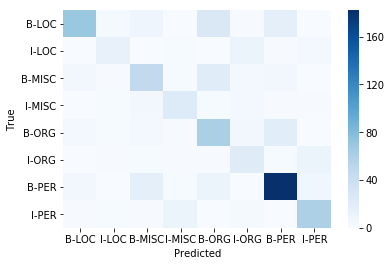

In [25]:
# Confusion matrices

model_name = f'./models/crf_27_11_19_mixed.pickle'

with open(model_name,'rb') as f:
    clf = pickle.load(f)

y_pred = clf.predict(test['x'])

flat_pred = [i for y in y_pred for i in y]
flat_true = [i for y in test['y'] for i in y]

conf = confusion_matrix(flat_true, flat_pred, labels=sorted_labels)

conf_df = pd.DataFrame._from_arrays(conf, columns=sorted_labels, index=sorted_labels)

# conf_df
ax = sns.heatmap(data=conf_df, cmap='Blues')
ax.set(xlabel='Predicted', ylabel='True')

In [26]:
def sent_to_flat_frame(X):
    '''Takes list of lists (sentences) of dicts (feature vectors) of features.
    Returns multiindex where each row is a context window feature vector.
    '''

    flat_x = [(i,tok,sent) for sent,x in enumerate(X) for tok,i in enumerate(x)]
    
    features = [i for i,_,_ in flat_x]
    token_id = [j for _,j,_ in flat_x]
    sentence_id = [k for _,_,k in flat_x]


    df = pd.DataFrame.from_records(features)
    df['token_id'] = pd.Series(token_id)
    df['sentence_id'] = pd.Series(sentence_id)
    df.set_index(['sentence_id','token_id'], drop=True, inplace=True)

    return df


def importances(clf, scorer, X, y_true, labels, columns_to_shuffle=None, n_iters=3):
    '''Shuffles the input on each feature column and reports the drop in performance.
    '''

    y_pred = clf.predict(X)
    
    base_score = scorer(y_true, y_pred, average='weighted', labels=labels)

    reductions = {}

    X_flat = sent_to_flat_frame(X)

    if columns_to_shuffle is None:
        columns_to_shuffle = X_flat.columns
    
    for c in columns_to_shuffle:
        print(f'Shuffling on {c}')
        reductions_c = []
        for _ in range(n_iters):
            X_flat_copy = X_flat.copy() 
            X_flat_copy[c] = np.random.permutation(X_flat[c].values)
            sents = X_flat_copy.groupby(level='sentence_id'
                              ).apply(lambda sent: [{k:v for k,v in m.items() if pd.notnull(v)} for m in sent.to_dict('records')])
            y_pred = clf.predict(sents)
            c_score = scorer(y_true, y_pred, average='weighted', labels=labels)
            reductions_c.append(-c_score + base_score)
        reductions[c] = reductions_c
    
    return (base_score,reductions)

In [0]:
# Permutation importance

models = ['crf_25_11_19_conll','crf_25_11_19_wnut','crf_27_11_19_mixed']
test = dists['tweets']

for model in models:

    model_name = f'./models/{model}.pickle'

    with open(model_name,'rb') as f:
        clf = pickle.load(f)

    log_print('Feature importances for '+model_name)

    base_score, reductions = importances(clf, metrics.flat_f1_score, test['x'], test['y'], labels)

    feature_importances = {k:{'mean':np.mean(v),'std':np.std(v)} for k,v in reductions.items()}
    fi_sorted = sorted(feature_importances.items(), key=lambda x: x[1]['mean'], reverse=True)
    
    log_print(str(fi_sorted))


In [0]:
fi_sorted

In [0]:
# if os.name == 'nt':
#     _x = [s['c1'] for s in rs.cv_results_['params']]
#     _y = [s['c2'] for s in rs.cv_results_['params']]
#     _c = [round(s,2) for s in rs.cv_results_['mean_test_score']]

#     fig = plt.figure()
#     fig.set_size_inches(12, 12)
#     ax = plt.gca()
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlabel('C1')
#     ax.set_ylabel('C2')
#     ax.set_title("Randomized Hyperparameter Search Sampled CV Results (min={:0.3}, max={:0.3})".format(
#         min(_c), max(_c)
#     ))

#     sns.scatterplot(x=_x, y=_y, hue=_c, size=_c, ax=ax)

#     # ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

#     print(f'Dark blue => {round(min(_c),3)}, dark red => {round(max(_c),3)}')

#     logging.info('Evaluation successful.')